In [46]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline    

In [47]:
df=pd.read_csv('daily_2009_to_2021.csv')
df.head()
lookback = 12 # choose sequence length
pct = 0.18

In [48]:
df.shape

(3150, 7)

In [49]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [50]:
df = df.dropna()

In [51]:
date = df['Date']

In [52]:
from sklearn.preprocessing import MinMaxScaler
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

<ipython-input-52-d8240393cc24>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
price['Close'] 

0      -0.940442
1      -0.931048
2      -0.932136
3      -0.956331
4      -0.962292
          ...   
3145    0.866636
3146    0.877552
3147    0.866448
3148    0.881689
3149    0.817579
Name: Close, Length: 3150, dtype: float64

In [54]:
def split_data(stock, lookback,pct):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(pct*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
x_train, y_train, x_test, y_test = split_data(price, lookback,pct)

In [55]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
#y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
#y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [56]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [57]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True )
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [58]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [59]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.3171384334564209
Epoch  1 MSE:  0.192189559340477
Epoch  2 MSE:  0.1001385748386383
Epoch  3 MSE:  0.08281270414590836
Epoch  4 MSE:  0.096501924097538
Epoch  5 MSE:  0.06794552505016327
Epoch  6 MSE:  0.06447840481996536
Epoch  7 MSE:  0.07002591341733932
Epoch  8 MSE:  0.07127310335636139
Epoch  9 MSE:  0.06551904231309891
Epoch  10 MSE:  0.054486699402332306
Epoch  11 MSE:  0.04334080219268799
Epoch  12 MSE:  0.04104844480752945
Epoch  13 MSE:  0.044924311339855194
Epoch  14 MSE:  0.033498529344797134
Epoch  15 MSE:  0.020102523267269135
Epoch  16 MSE:  0.018144769594073296
Epoch  17 MSE:  0.017264649271965027
Epoch  18 MSE:  0.008199087344110012
Epoch  19 MSE:  0.006106230895966291
Epoch  20 MSE:  0.012972382828593254
Epoch  21 MSE:  0.005692210514098406
Epoch  22 MSE:  0.010357175953686237
Epoch  23 MSE:  0.011027194559574127
Epoch  24 MSE:  0.005380640272051096
Epoch  25 MSE:  0.004440957214683294
Epoch  26 MSE:  0.005008082836866379
Epoch  27 MSE:  0.00288646342

In [60]:
predict = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(y_train_pred.detach().numpy())))
original = pd.DataFrame(scaler.inverse_transform(pd.DataFrame(y_train_lstm.detach().numpy())))

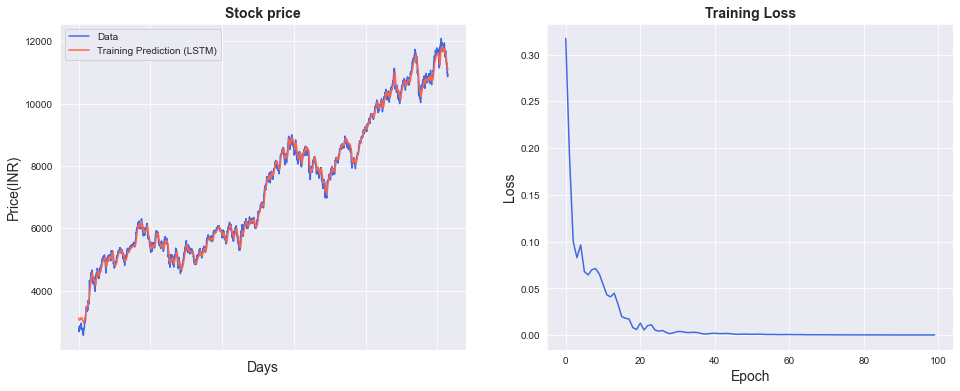

In [61]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price(INR)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [62]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 136.55 RMSE
Test Score: 1039.57 RMSE


In [63]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [64]:
result['date']=date

In [65]:
result

,0,1,2,date
0,NaN,NaN,3046.750000,02/01/2009
1,NaN,NaN,3121.449951,05/01/2009
2,NaN,NaN,3112.800049,06/01/2009
3,NaN,NaN,2920.399902,07/01/2009
4,NaN,NaN,2873.000000,09/01/2009
...,...,...,...,...
3145,NaN,15279.998047,17416.550780,22/11/2021
3146,NaN,15276.023438,17503.349610,23/11/2021
3147,NaN,15267.784180,17415.050780,24/11/2021
3148,NaN,15254.072266,17536.250000,25/11/2021


In [66]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.date, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.date, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.date, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        title_text='Date',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='black',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (INR)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='black',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='black',
        ),
    ),
    showlegend=True,
    template = 'plotly_white'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='black'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()


In [67]:
a = y_test[:,0] 
b = y_test_pred[:,0]
a.shape

(565,)